# Effect of Primary Beam in the HI Power Spectrum

The delay transformed visibility data is in the unit of JyHz. The resulting delay power spectrum can be converted to brightness temperature power spectrum using the following equation (see [1304.4991](https://arxiv.org/pdf/1304.4991.pdf) for definitions and derivations):

$$
P_{\rm T}(k) = \frac{X^2 Y}{\Omega_{\rm PP}B}\bigg(\frac{\lambda^2}{2k_{\rm B}}\bigg)^2P_{\rm d}(u,v,\eta)
$$

The quantity we are interested in here is $\Omega_{\rm pp}$:
$$
\Omega_{\rm pp} = \int {\rm d}l{\rm d}m |A(l,m)|^2
$$

In this notebook, we are aiming to showcase some popular primary beam models for MeerKAT dishes and quantify the effect of the primary beam.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units, constants
import sys
sys.path.append('/idia/projects/mightee/zchen/hiimtool/src/')
from hiimtool.hiimvis import  Specs
from astropy.cosmology import Planck18_arXiv_v2 as Planck18
from scipy.special import j1
from astropy.io import fits

Following [2011.10815](https://arxiv.org/pdf/2011.10815.pdf), we adopt the following primary beam models. The FWHM of the beam is set to be:

$$
{\Delta \theta} = 1.155 \frac{\lambda}{\rm D}
$$

where $\lambda$ is the observing frequency and D is the dish diameter. The coefficient 1.155 is taken at our observing frequency around $z\sim 0.32$. The shape of the beam can be approximated by several models, such as Gaussian, Jinc and Cosine.

The Gaussian beam has the form:

$$
A_{\rm G} = {\rm Exp}\big[-4{\rm ln}2\frac{\theta^2}{\Delta \theta^2}\big]
$$

The Jinc beam has the form:

$$
A_{\rm J} = \Big[2{\rm jinc}\big(\pi\theta/\Delta\theta\big)\Big]^2
$$

The Cosine beam has the form:

$$
A_{\rm C} = \Big[\frac{{\rm cos}(1.189\theta\pi/\Delta\theta)}{1-4(1.189\theta/\Delta\theta)^2}\Big]^2
$$

For comparison we also show an unphysical beam model with the beam following the jinc function instead of the jinc function squared. The Fourier transform of this beam is a top hat function. In real space it has:

$$
A_{\rm T} = 2{\rm jinc}\Big(\frac{\pi\theta}{\sqrt{2}\Delta\theta}\Big)
$$

In [3]:
sp = Specs(cosmo = Planck18,
           freq_start_hz = 1054535156.25,
           num_channels = 220,
           deltav_ch = 208984.375,
           FWHM_ref = 83.94201153142113/60*np.pi/180,
           FWHM_freq_ref = 1050e6,)

def cosbeam(theta,fwhm=1.155*sp.lambda_0()/13.5):
    result = (np.cos(1.189*theta*np.pi/fwhm)/(1-4*(1.189*theta/fwhm)**2))**2
    return result

def gaussbeam(theta,fwhm=1.155*sp.lambda_0()/13.5):
    result = np.exp(-4*np.log(2)*theta**2/fwhm**2)
    return result

def jincbeam(theta,fwhm=1.155*sp.lambda_0()/13.5):
    inarr = np.pi*theta/fwhm
    result = (np.nan_to_num((2*(j1(inarr)/inarr))**2)*(inarr!=0)+1*(inarr==0))
    return result

def tophatbeam(theta,fwhm=1.155*sp.lambda_0()/13.5):
    inarr = np.pi*theta/fwhm*np.sqrt(2)
    result = (np.nan_to_num((2*(j1(inarr)/inarr)))*(inarr!=0)+1*(inarr==0))
    return result

In [36]:
sp.freq_0()

1076932906.1499856

In [4]:
fwhm = 1.155*sp.lambda_0()/13.5

In [8]:
thetaarr = np.linspace(0,5.0,100)*np.pi/180

/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


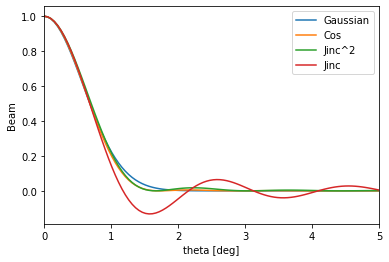

In [10]:
plt.plot(thetaarr*180/np.pi,gaussbeam(thetaarr),label='Gaussian')
plt.plot(thetaarr*180/np.pi,cosbeam(thetaarr),label='Cos')
plt.plot(thetaarr*180/np.pi,jincbeam(thetaarr),label='Jinc^2')
plt.plot(thetaarr*180/np.pi,jincsqbeam(thetaarr),label='Jinc')
plt.xlabel('theta [deg]')
plt.ylabel('Beam')
plt.xlim(0,5)
plt.legend()

The primary beam area, defined as $\Omega = \int {\rm dldm} A(l,m)$, can be calculated:

In [20]:
def calomega(beam):
    xarr = np.linspace(-10.0,10.0,1000)*np.pi/180
    angres = xarr[1]-xarr[0]
    area = np.sum(beam(np.sqrt(xarr[:,None]**2+xarr[None,:]**2)))*angres**2
    return area

def calomegapp(beam):
    xarr = np.linspace(-10.0,10.0,1000)*np.pi/180
    angres = xarr[1]-xarr[0]
    area = np.sum(beam(np.sqrt(xarr[:,None]**2+xarr[None,:]**2))**2)*angres**2
    return area

In [21]:
omega_g,omega_c,omega_j,omega_t = calomega(gaussbeam),calomega(cosbeam),calomega(jincbeam),calomega(tophatbeam)
omega_g,omega_c,omega_j,omega_t

(0.0006427246600055928,
 0.0006011555652779599,
 0.000704162037521882,
 0.0003541795948055588)

The power squared beam area is:

In [22]:
omegapp_g,omegapp_c,omegapp_j,omegapp_t = calomegapp(gaussbeam),calomegapp(cosbeam),calomegapp(jincbeam),calomegapp(tophatbeam)
omegapp_g,omegapp_c,omegapp_j,omegapp_t

(0.0003213623300027963,
 0.0003143476195062225,
 0.0003319473340903254,
 0.00035473767125035634)

Note that for quite different FoV from these models, the power squared beam areas actually agree quite well. One can see this in Fourier space:

In [27]:
xarr = np.linspace(-15.0,15.0,2000)*np.pi/180
kxarr = np.fft.fftfreq(len(xarr),d=xarr[1]-xarr[0])
kfield = np.sqrt(kxarr[:,None]**2+kxarr[None,:]**2)
kthetaedges = np.linspace(0,kfield.max()/50,40)[1:]
k1dcen = np.diff(kthetaedges)/2+kthetaedges[:-1]
indx = (kfield[:,:,None]>kthetaedges[None,None,:-1])*(kfield[:,:,None]<=kthetaedges[None,None,1:])
def f_beam(beam):
    beam_f = np.fft.fft2(beam(np.sqrt(xarr[:,None]**2+xarr[None,:]**2)))
    beam_f /= np.abs(beam_f).max()
    beam_f = np.abs(beam_f)
    beam_f1d = (np.sum(beam_f[:,:,None]*indx,axis=(0,1))/np.sum(indx,axis=(0,1)))
    return beam_f1d

In [32]:
beamf_g,beamf_c,beamf_j,beamf_t = f_beam(gaussbeam),f_beam(cosbeam),f_beam(jincbeam),f_beam(tophatbeam)

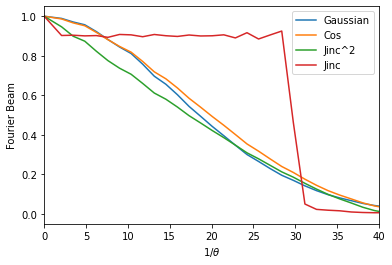

In [34]:
plt.plot(np.append(0,k1dcen),np.append(1,beamf_g),label='Gaussian')
plt.plot(np.append(0,k1dcen),np.append(1,beamf_c),label='Cos')
plt.plot(np.append(0,k1dcen),np.append(1,beamf_j),label='Jinc^2')
plt.plot(np.append(0,k1dcen),np.append(1,beamf_t),label='Jinc')
plt.xlabel(r'$1/\theta$')
plt.ylabel('Fourier Beam')
plt.xlim(0,40)
plt.legend()

You can see although the top hat has much less area, the power square of it in Fourier space is much larger due to the step function shape. Since the "normal beam area" is much more widely used, sometimes a factor is introduced so that:

$$
\Omega_{\rm PP} = F_{\rm PP}*\Omega
$$

In [35]:
(omegapp_g/omega_g,omegapp_c/omega_c,omegapp_j/omega_j,omegapp_t/omega_t)

(0.49999999999999983,
 0.5229056132265459,
 0.47140759711859653,
 1.0015756877386004)

One can see that, top hat gives a factor of 1 as expected since $1^2=1$. For Gaussian beam one can analytically calculate this factor to be 2. Most of the beam models for dish arrays are similar to Gaussian in Fourier space, and thus we expect this factor to be $\sim 2$.

Using [eidos](https://github.com/ratt-ru/eidos) to simulate the stokes I beam at the central frequency of 1077MHz (this is done by `eidos -p 2048 -d 10 -f 1077 -S I`) we have:

In [41]:
hdul = fits.open('/idia/projects/mightee/zchen/primary_beam_mh_1077MHz_10deg_I_re.fits')
beam_e = hdul[0].data[0,0,0]
beam_e = beam_e.astype('float32')
hdul.close()

In [43]:
angres = 10*np.pi/180/2048

In [46]:
omega_e = np.sum(beam_e)*angres**2
omegapp_e = np.sum(beam_e**2)*angres**2

In [47]:
omega_g,omega_c,omega_j,omega_e

(0.0006427246600055928,
 0.0006011555652779599,
 0.000704162037521882,
 0.0006038430494780259)

In [48]:
omegapp_g,omegapp_c,omegapp_j,omegapp_e

(0.0003213623300027963,
 0.0003143476195062225,
 0.0003319473340903254,
 0.0003114669668997865)

The Cosine beam describes the feature of the primary beam the best among all the models. If we compare this power squared beam model with assuming an apeture efficiency of 0.7:

In [49]:
Ae = 0.7* np.pi* ((13.5/2.)**2)  # Effective area
omega_ae = sp.lambda_0()**2/Ae

In [52]:
omega_ae,omegapp_e

(0.0007734079875666655, 0.0003114669668997865)

One can see it's roughly a factor of 2.5 off